In [1]:
from util import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.')
from tqdm import tqdm
import math

from dask.diagnostics import ProgressBar

import kora.install.rdkit
# from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
# from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys

In [2]:
train = pd.read_csv(join(PATH.INPUT, 'train.csv'))
dev   = pd.read_csv(join(PATH.INPUT, 'dev.csv'))
test  = pd.read_csv(join(PATH.INPUT, 'test.csv'))
ss    = pd.read_csv(join(PATH.OUTPUT, 'sample_submission.csv'))

train = pd.concat([train, dev])
train['ST1_GAP(eV)'] = train['S1_energy(eV)'] - train['T1_energy(eV)']

In [3]:
ffpp = 'pattern'

train_fps = []
train_y   = []
for index, row in train.iterrows():
    try:
        mol = Chem.MolFromSmiles(row['SMILES'])
        if ffpp == 'maccs':
            fp = MACCSkeys.GenMACCSKeys(mol)
        elif ffpp == 'morgan':
            fp = Chem.AllChem.GetMorganFingerprintAsBitVect(Mol, 4)
        elif ffpp == 'rdkit':
            fp = Chem.RDKFingerprint(mol)
        elif ffpp == 'pattern':
            fp = Chem.rdmolops.PatternFingerprint(mol)
        elif ffpp == 'layerd':
            fp = Chem.rdmolops.LayeredFingerprint(mol)
        train_fps.append(fp)
        train_y.append(row['ST1_GAP(eV)'])
    except:
        pass

np_train_fps = []
for fp in train_fps:
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_train_fps.append(arr)
np_train_fps_array = np.array(np_train_fps)
train_y = np.array(train_y)


test_fps = []  # test fingerprints
test_y   = []  # test y(label)
for index, row in test.iterrows():
    try:
        mol = Chem.MolFromSmiles(row['SMILES'])
        if ffpp == 'maccs':
            fp = MACCSkeys.GenMACCSKeys(mol)
        elif ffpp == 'morgan':
            fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 4)
        elif ffpp == 'rdkit':
            fp = Chem.RDKFingerprint(mol)
        elif ffpp == 'pattern':
            fp = Chem.rdmolops.PatternFingerprint(mol)
        elif ffpp == 'layerd':
            fp = Chem.rdmolops.LayeredFingerprint(mol)
        test_fps.append(fp)
    except:
        pass

np_test_fps = []
for fp in test_fps:
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_test_fps.append(arr)
np_test_fps_array = np.array(np_test_fps)

    
print(np_train_fps_array.shape, train_y.shape)
print(pd.Series(np_train_fps_array[:, 0]).value_counts())
# np_train_fps_array = np.delete(np_train_fps_array,0,1)

print()
print(np_test_fps_array.shape)
print(pd.Series(np_test_fps_array[:, 0]).value_counts())

(30345, 2048) (30345,)
0.0    30035
1.0      310
dtype: int64

(602, 2048)
0.0    594
1.0      8
dtype: int64


# 모델링

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

RS = 42
X_train, y_train = shuffle(np_train_fps_array, np.array(train_y), random_state=RS)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=RS)
X_test = np_test_fps_array

N_TRAIN, D = X_train.shape
N_VAL, D   = X_val.shape
N_TEST, _  = X_test.shape

print('train:', X_train.shape, y_train.shape)
print('val:', X_val.shape, y_val.shape)
print('test:', X_test.shape)

train: (21241, 2048) (21241,)
val: (9104, 2048) (9104,)
test: (602, 2048)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def get_mlp_model(input_dim):
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    
    try:
        for gpu in tf.config.experimental.list_physical_devices('GPU'):
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
    
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
        model = Sequential([
            Dense(2048, input_dim=input_dim),
            Activation('relu'),
            Dense(1024),
            Activation('relu'),
            Dense(128),
            Activation('relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mean_absolute_error')
    model.summary()
    return model

model = get_mlp_model(D)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
activation (Activation)      (None, 2048)             

In [6]:
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

### Callbacks
ckpt_dir_path   = join(PATH.ROOT, 'model')
result_dir_path = join(PATH.ROOT, 'result')

os.makedirs(ckpt_dir_path, exist_ok=True)
os.makedirs(result_dir_path, exist_ok=True)


class LossPlot(Callback):
    def __init__(self, PLOT_PATH):
        self.PLOT_PATH = PLOT_PATH
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.idx_min = -1
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.idx_min = np.argmin(self.val_losses)
        self._save_fig()
    def _save_fig(self):
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(self.losses, label='train')
        ax.plot(self.val_losses, '--', linewidth=2, label='val')
        ax.axvline(self.idx_min, color='r', ls='--', lw=3)
        ax.set_xlabel('epochs');  ax.set_ylabel('loss')
        ax.grid();  ax.legend(fontsize='x-large')
        fig.savefig(self.PLOT_PATH)
        plt.close(fig)
        

callbacks = [
    ModelCheckpoint(join(ckpt_dir_path, "epoch:{epoch}(val_loss:{val_loss:.4f})"), save_weights_only=True),
    CSVLogger(join(result_dir_path, 'log.csv')),
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, min_lr=1e-3, patience=5, verbose=1),
    TensorBoard(log_dir=join(PATH.ROOT, 'logs'), write_graph=True, write_images=True),
    LossPlot(join(result_dir_path, 'loss.png'))
]

history = model.fit(X_train, y_train, epochs=50, validation_split=0.3, callbacks=callbacks, workers=os.cpu_count(), use_multiprocessing=True)

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
465/465 [==============================] - ETA: 0s - loss: 0.2807INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
465/465 [==============================] - 7s 9ms/step - loss: 0.2807 - val_loss: 0.

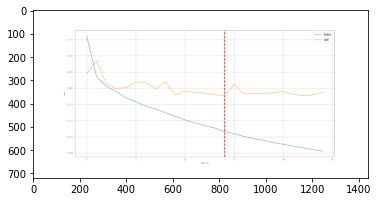

In [7]:
img = Image.open(join(result_dir_path, 'loss.png'))
plt.imshow(img);

In [8]:
val_loss = model.evaluate(X_val, y_val)
val_loss

285/285 [==============================] - 1s 3ms/step - loss: 0.1843


0.1843329668045044

In [9]:
y_test = model.predict(X_test)
y_test = y_test.flatten()
y_test[y_test < 0] = 0

# 추론 및 제출 

In [10]:
input()

KeyboardInterrupt: Interrupted by user

In [ ]:
ss['ST1_GAP(eV)'] = y_test
ss.to_csv(join(PATH.OUTPUT, 'pattern_mlp.csv'), index=False)

In [ ]:
from dacon_submit_api import dacon_submit_api

result = dacon_submit_api.post_submission_file(
    join(PATH.OUTPUT, 'pattern_mlp.csv'),
    '542784023fe8a00bb17969fc1a171bc63699fd3ef71c94ecac9a81b3001080d3',
    '235789',
    'Torch',
    'pattern_mlp'
)